In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import datetime
import seaborn as sns
import scipy as sc

In [202]:
shops = pd.read_csv("data/shops.csv")
items = pd.read_csv("data/items.csv")
item_categories = pd.read_csv("data/item_categories.csv")
test = pd.read_csv("data/test.csv")
sales_train = pd.read_csv("data/sales_train.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [203]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [204]:
grouped_sales_train = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

fig = go.Figure()
for shop_id in grouped_sales_train['shop_id'].unique():
        data = grouped_sales_train[grouped_sales_train['shop_id'] == shop_id]
        fig.add_trace(go.Scatter(x=data['date_block_num'], y=data['item_cnt_day'],
                    mode='lines+markers',
                    name='shop_id: '+ str(shop_id)))
fig.update_layout(legend_orientation="h", width=1600, height=1000, title="Plotting total 'item_cnt_day' amount across a 'date_block_num' for each 'shop_id'")
fig.show()

In [205]:
grouped_sales_train.head()

,shop_id,date_block_num,item_cnt_day
0,0,0,5578.0
1,0,1,6127.0
2,1,0,2947.0
3,1,1,3364.0
4,2,0,1146.0


### Clustering `item_cnt_day` for each `shop_id` per `date_block_num`

In [206]:
# Creating a timeseries df
timeSeries = pd.DataFrame()

for shop_id in grouped_sales_train['shop_id'].unique():
    shop_data_frame = pd.DataFrame(grouped_sales_train[grouped_sales_train['shop_id'] == shop_id]).filter(['date_block_num','item_cnt_day'])
    shop_data_frame = shop_data_frame.set_index('date_block_num')
    
    # adding missing date_block_num indexes with NaN values
    shop_data_frame = shop_data_frame.reindex(range(33))
    
    # filling the NaN values
    shop_data_frame = shop_data_frame.fillna(random.randint(0, 1000))
    
    # adding the preprocessed shop dataframe to the timeSeries dataframe
    shop_data_frame = [item_cnt[0] for item_cnt in shop_data_frame.values.tolist()]
    shop_data_frame = pd.DataFrame([shop_data_frame], index=[shop_id])
    timeSeries = timeSeries.append(shop_data_frame)

In [207]:
timeSeries

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,5578.0,6127.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
1,2947.0,3364.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,1921.0,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,1275.0,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,2071.0,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0
5,481.0,877.0,1355.0,1008.0,1110.0,1393.0,1265.0,1510.0,1298.0,1267.0,...,2127.0,1404.0,1101.0,1109.0,1054.0,1012.0,954.0,991.0,1294.0,1092.0
6,3686.0,4007.0,4519.0,3168.0,3022.0,3847.0,3360.0,3702.0,4208.0,3675.0,...,4115.0,2328.0,2329.0,1981.0,1998.0,1748.0,1539.0,1484.0,1575.0,1725.0
7,2495.0,2513.0,2460.0,1540.0,1647.0,2085.0,2031.0,2397.0,2599.0,2236.0,...,3318.0,2084.0,1847.0,1430.0,1340.0,1217.0,1235.0,1327.0,1409.0,1287.0
8,1463.0,1156.0,977.0,-1.0,742.0,742.0,742.0,742.0,742.0,742.0,...,742.0,742.0,742.0,742.0,742.0,742.0,742.0,742.0,742.0,742.0
9,842.0,842.0,842.0,842.0,842.0,842.0,842.0,842.0,842.0,6526.0,...,842.0,842.0,842.0,842.0,-1.0,842.0,842.0,842.0,842.0,842.0


In [208]:
type(timeSeries)

pandas.core.frame.DataFrame

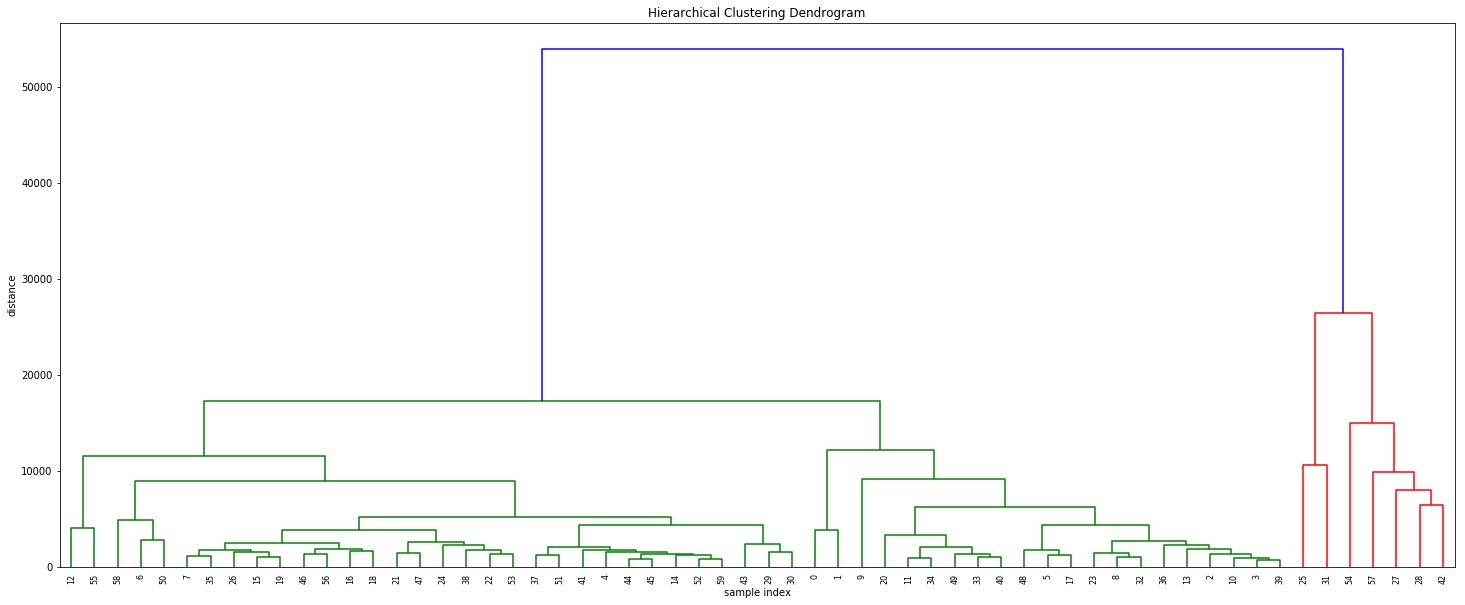

Cluster 2 number of entries 21
Cluster 1 number of entries 32
Cluster 3 number of entries 2
Cluster 4 number of entries 4
Cluster 5 number of entries 1


In [209]:
from math import sqrt

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

def spearman_correlation(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2

Z = hac.linkage(timeSeries, method='complete', metric=DTWDistance)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# retrieving clusters, k is the number of clusters we want
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(timeSeries, Z, 5, plot=False)

### Clustering `item_category_id` based on  `item_cnt_day` per `date_block_num`

In [210]:
train = sales_train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train.head()
grouped_sales_train = pd.DataFrame(train.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig = go.Figure()
for item_cat in grouped_sales_train['item_category_id'].unique():
        data = grouped_sales_train[grouped_sales_train['item_category_id'] == item_cat]
        fig.add_trace(go.Scatter(x=data['date_block_num'], y=data['item_cnt_day'],
                    mode='lines+markers',
                    name='item cat: '+ str(item_cat)))
fig.update_layout(legend_orientation="h", width=1600, height=1000, title="Plotting total 'item_cnt_day' amount across a 'date_block_num' for each 'item_category_id'")
fig.show()

In [211]:
grouped_sales_train

,item_category_id,date_block_num,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,3,1.0
3,1,0,1.0
4,1,1,1.0
5,2,0,1390.0
6,2,1,1190.0
7,2,2,1025.0
8,2,3,646.0
9,2,4,596.0


In [212]:
# Creating a timeseries df
cat_timeSeries = pd.DataFrame()

for cat_id in grouped_sales_train['item_category_id'].unique():
    cat_data_frame = pd.DataFrame(grouped_sales_train[grouped_sales_train['item_category_id'] == cat_id]).filter(['date_block_num','item_cnt_day'])
    cat_data_frame = cat_data_frame.set_index('date_block_num')
    
    # adding missing date_block_num indexes with NaN values
    cat_data_frame = cat_data_frame.reindex(range(33))
    
    # filling the NaN values
    cat_data_frame = cat_data_frame.fillna(random.randint(0, 10))
    
    # adding the preprocessed category item dataframe to the timeSeries dataframe
    cat_data_frame = [item_cnt[0] for item_cnt in cat_data_frame.values.tolist()]
    cat_data_frame = pd.DataFrame([cat_data_frame], index=[cat_id])
    cat_timeSeries = cat_timeSeries.append(cat_data_frame)

In [213]:
cat_timeSeries

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,790.0,...,573.0,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0
3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,391.0,...,2459.0,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0
4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,89.0,...,20.0,10.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
5,623.0,358.0,354.0,275.0,281.0,329.0,355.0,299.0,289.0,257.0,...,276.0,178.0,85.0,88.0,67.0,44.0,51.0,48.0,45.0,31.0
6,870.0,668.0,646.0,465.0,441.0,502.0,622.0,637.0,729.0,1016.0,...,1139.0,700.0,400.0,334.0,266.0,274.0,319.0,243.0,277.0,237.0
7,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1677.0,639.0,220.0,269.0,244.0,217.0,238.0,178.0,307.0,244.0
8,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,45.0,147.0,117.0,193.0,483.0,5128.0
9,149.0,159.0,211.0,138.0,95.0,124.0,83.0,124.0,141.0,253.0,...,1129.0,467.0,480.0,492.0,1003.0,2005.0,528.0,513.0,276.0,816.0


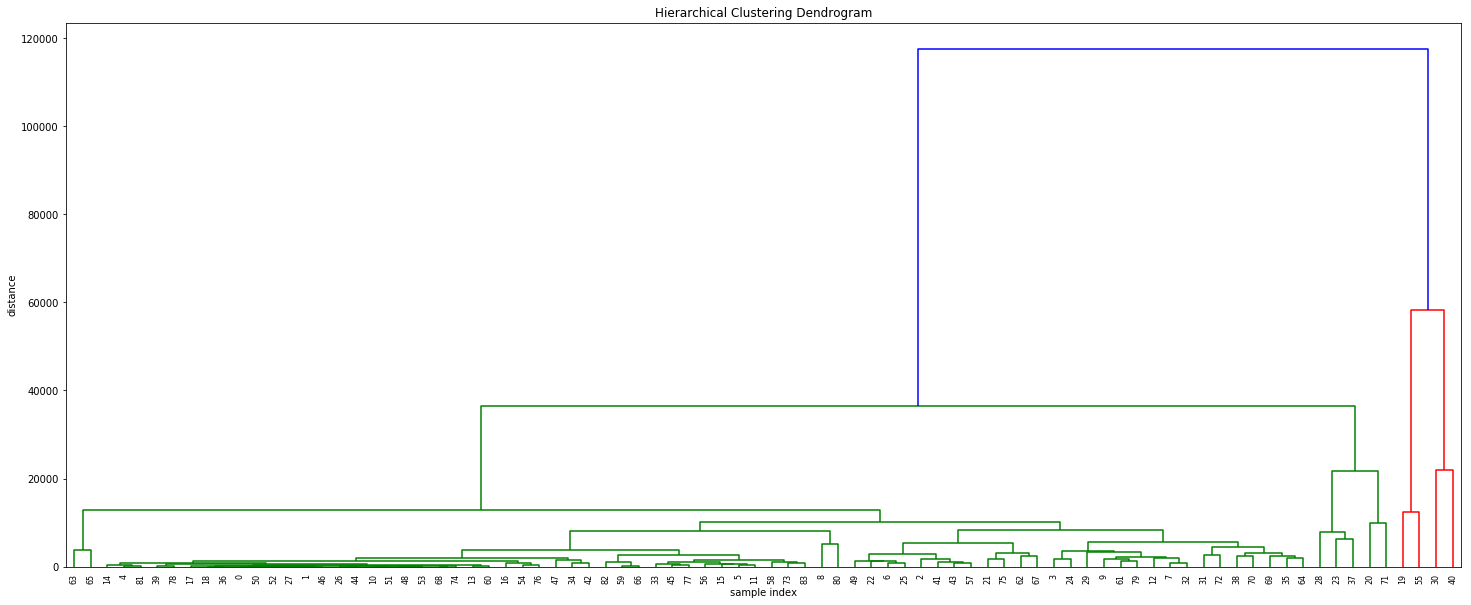

Cluster 1 number of entries 75
Cluster 3 number of entries 2
Cluster 2 number of entries 5
Cluster 4 number of entries 1
Cluster 5 number of entries 1


In [214]:
from math import sqrt

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

def spearman_correlation(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2

Z = hac.linkage(cat_timeSeries, method='complete', metric=DTWDistance)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# retrieving clusters, k is the number of clusters we want
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(cat_timeSeries, Z, 5, plot=False)